## Bert Multi-class fine-tuning 

In [102]:
!pip install transformers

In [103]:
import transformers
import torch
import pandas as pd
from tqdm.notebook import tqdm
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils import data
import numpy as np
from transformers import AdamW # optimizer
from transformers import get_linear_schedule_with_warmup # for learning rate
from transformers import BertModel

In [104]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [105]:
dataset = pd.read_csv("sample_data/new_label_dataset.csv")[['content', 'priority']]
testset = pd.read_csv("sample_data/new_label_testset.csv")[['content', 'priority']]
dataset = dataset[dataset['priority'] != 'Unknown'].reset_index(drop=True)
testset = testset[testset['priority'] != 'Unknown'].reset_index(drop=True)

print("size of train set: ", len(dataset))
print("size of test set: ", len(testset))

for i in tqdm(range(len(dataset))):
    if dataset.loc[i, 'priority'] == 'Critical': dataset.loc[i, 'priority'] = 0
    elif dataset.loc[i, 'priority'] == 'High': dataset.loc[i, 'priority'] = 1
    elif dataset.loc[i, 'priority'] == 'Medium': dataset.loc[i, 'priority'] = 2
    elif dataset.loc[i, 'priority'] == 'Low': dataset.loc[i, 'priority'] = 3
    else:
        pass

for i in tqdm(range(len(testset))):
    if testset.loc[i, 'priority'] == 'Critical': testset.loc[i, 'priority'] = 0
    elif testset.loc[i, 'priority'] == 'High': testset.loc[i, 'priority'] = 1
    elif testset.loc[i, 'priority'] == 'Medium': testset.loc[i, 'priority'] = 2
    elif testset.loc[i, 'priority'] == 'Low': testset.loc[i, 'priority'] = 3
    else:
        pass 

size of train set:  29113
size of test set:  8179


In [106]:
dataset[:3]

,content,priority
0,philippine flood worsen death toll hit wake ge...,3
1,philippine flood fatality hit,3
2,luzon dam release water flood warn up manila p...,3


In [107]:
class GPRreviewDataset(data.Dataset):
    def __init__(self, content, target, tokenizer, max_len):
        self.content = content
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.content)
    
    def __getitem__(self, item):
        content = str(self.content[item])
        encoding = tokenizer.encode_plus(
            content,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'text': content,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }

In [108]:
MAX_LEN = 30
BATCH_SIZE = 64

# df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=2020)

df_train, df_test = dataset, testset

In [109]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPRreviewDataset(
        content = df.content.to_numpy(),
        target = df.priority.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len,
    )
    return data.DataLoader(
        ds, 
        batch_size = batch_size,
    )

In [110]:
train_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [111]:
from transformers import BertForSequenceClassification

In [112]:
# class BertClassifier(nn.Module):
#     def __init__(self, n_class):
#         super(BertClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained("bert-base-uncased")
#         self.drop = nn.Dropout(p=0.3)
#         self.out = nn.Linear(self.bert.config.hidden_size, n_class)
        
#     def forward(self, input_ids, attention_mask):
#         _, pooled_output = self.bert(
#             input_ids = input_ids,
#             attention_mask = attention_mask
#         )
#         output = self.drop(pooled_output)
#         output1 = self.out(output)
#         return output1

In [113]:
device = 'cuda'
# model = BertClassifier(4).to(device)

In [114]:
from transformers import BertForSequenceClassification


# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 4,  
    output_attentions = False,
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [115]:
def train(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = 0
    correct_predictions = 0
    for d in data_loader:
        optimizer.zero_grad()
        
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        # output = model(input_ids = input_ids, attention_mask = attention_mask)
        loss, logits = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=targets)
        
        # _, preds = torch.max(output, dim=1)
        # loss = loss_fn(output, targets)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses+=loss.item()
    return losses/len(data_loader)

In [116]:
def val(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = 0
    preds_list, targets_list, prob_list = [], [], []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            # output = model(input_ids = input_ids, attention_mask = attention_mask)
            loss, logits = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=attention_mask,
                                   labels=targets)
            # _, preds = torch.max(output, dim=1)
            # loss = loss_fn(output, targets)

            losses+=loss.item()
            # logits = logits.detach().cpu().numpy()
            # preds_list.append(preds)
            # targets_list.append(targets)
            # prob_list.append(output)
            # , preds_list, targets_list, prob_list
    return losses/len(data_loader)

In [117]:
EPOCHS = 30
train_loss_list, val_loss_list = [], []

weight = torch.tensor([0.0348, 0.0941, 0.1742, 0.7220])

total_steps = len(train_loader) * EPOCHS

loss_fn = nn.CrossEntropyLoss(weight=weight).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

for epoch in tqdm(range(EPOCHS)):
    train_loss = train(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    # , preds_list, targets_list, prob_list
    val_loss = val(
        model,
        test_loader,
        loss_fn,
        device,
        len(df_test)
    )

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print("train loss: ", train_loss, "val loss:", val_loss)

train loss:  0.8627475146982041 val loss: 0.4863928991544526
train loss:  0.8152681816573981 val loss: 0.4844004231854342
train loss:  0.7926777448955473 val loss: 0.48696766450302675
train loss:  0.7742654220907242 val loss: 0.4799807229428552
train loss:  0.7399891300188316 val loss: 0.4952063990640454
train loss:  0.7125110028209267 val loss: 0.494037376367487
train loss:  0.6957001698377369 val loss: 0.5091740708448924
train loss:  0.6538823597542532 val loss: 0.5174540824664291
train loss:  0.6200116032918731 val loss: 0.5525896592880599
train loss:  0.5803279516133634 val loss: 0.5808058762340806
train loss:  0.54593296074769 val loss: 0.5745934486039914
train loss:  0.5124498160658302 val loss: 0.5910517583251931
train loss:  0.48006890599544233 val loss: 0.5946809161105193
train loss:  0.45546126585904056 val loss: 0.7014674090314656
train loss:  0.4248504238796758 val loss: 0.7105882372707129
train loss:  0.4098521724097676 val loss: 0.7041408224613406
train loss:  0.383536466

In [118]:
# score = 0

# for i in range(len(targets_list)):
#   index_list = targets_list[i]
#   for j, index in enumerate(index_list):
#     key = index.item()
#     if key == 0: weight = 1
#     elif key == 1: weight = 0.75
#     elif key == 2: weight = 0.5
#     elif key == 3: weight = 0.25
#     else: weight = 0

#     score += (weight - weight * prob_list[i][j][key].cpu().item())**2

# score /= len(testset)

# print("RMSE all: ", score)

Text(0.5, 1.0, 'train and test loss')

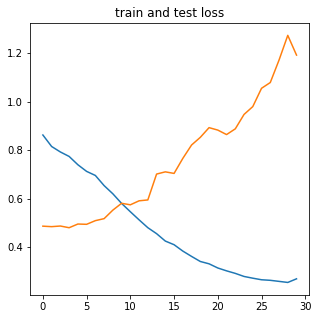

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([i for i in range(EPOCHS)], train_loss_list)
plt.plot([i for i in range(EPOCHS)], val_loss_list)
plt.title("train and test loss")

tutorial: 

https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://www.youtube.com/watch?v=8N-nM3QW7O0

https://www.youtube.com/watch?v=Osj0Z6rwJB4

https://mccormickml.com/2019/07/22/BERT-fine-tuning/

https://github.com/kaushaltrivedi/fast-bert